# End-to-End Multi-Model Pipeline — Train / Validate / Test
## 70 / 15 / 15 Split — Final Evaluation on Unseen Test Set

**Pipeline**:  
```
Raw CIR → Stage 1 (PI-HLNN: LOS/NLOS?) → Stage 2 (RF: Single/Multi bounce?) → Stage 3 (RF: Predict bias) → d_corrected
```

**Split**: 70% Train / 15% Validation / 15% Test (matching Xu Xueli 2024)  
**Test set**: Completely unseen — never used during training or hyperparameter tuning  

| Stage | Model | Features | Output |
|-------|-------|----------|--------|
| 1 | PI-HLNN (Liquid Neural Network) | Raw 60-sample CIR window | LOS (0) / NLOS (1) |
| 2 | Random Forest Classifier | 48-dim LNN embeddings (frozen Stage 1 PI-HLNN encoder) | Single-bounce (0) / Multi-bounce (1) |
| 3 | Random Forest Regressor | 48-dim LNN embeddings (frozen Stage 1 PI-HLNN encoder) | NLOS bias (meters) |

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import re
import copy
import joblib
from scipy.signal import find_peaks
from scipy.stats import kurtosis as scipy_kurtosis
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    classification_report, r2_score,
    mean_absolute_error, mean_squared_error
)
from torch.utils.data import DataLoader, TensorDataset

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

Device: cuda


---
## Section 1: Data Loading & 70/15/15 Split

Stratified split ensuring LOS/NLOS ratio preserved in all 3 sets.

In [2]:
# ==========================================
# GROUND TRUTH
# ==========================================
GROUND_TRUTH = {
    '7.79m':  {'d_direct': 7.79,  'd_bounce': 12.79, 'bias': 5.00},
    '10.77m': {'d_direct': 10.77, 'd_bounce': 16.09, 'bias': 5.32},
    '14m':    {'d_direct': 14.00, 'd_bounce': 16.80, 'bias': 2.80},
}

def get_distance_group(fname):
    match = re.match(r'^([\d.]+m)', str(fname))
    return match.group(1) if match else None

# ==========================================
# LOAD FULL DATASET
# ==========================================
df = pd.read_csv('../dataset/channels/combined_uwb_dataset.csv')
print(f'Total samples: {len(df)}')
print(f'  LOS:  {(df["Label"]==0).sum()}')
print(f'  NLOS: {(df["Label"]==1).sum()}')

# ==========================================
# 70 / 15 / 15 STRATIFIED SPLIT
# ==========================================
# First split: 70% train, 30% temp
train_df, temp_df = train_test_split(
    df, test_size=0.30, random_state=SEED, stratify=df['Label']
)
# Second split: 50/50 of temp -> 15% val, 15% test
val_df, test_df = train_test_split(
    temp_df, test_size=0.50, random_state=SEED, stratify=temp_df['Label']
)

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print(f'\nSplit Results:')
print(f'  Train: {len(train_df)} ({100*len(train_df)/len(df):.1f}%) — LOS={int((train_df["Label"]==0).sum())}, NLOS={int((train_df["Label"]==1).sum())}')
print(f'  Val:   {len(val_df)} ({100*len(val_df)/len(df):.1f}%) — LOS={int((val_df["Label"]==0).sum())}, NLOS={int((val_df["Label"]==1).sum())}')
print(f'  Test:  {len(test_df)} ({100*len(test_df)/len(df):.1f}%) — LOS={int((test_df["Label"]==0).sum())}, NLOS={int((test_df["Label"]==1).sum())}')

Total samples: 3600
  LOS:  1800
  NLOS: 1800

Split Results:
  Train: 2520 (70.0%) — LOS=1260, NLOS=1260
  Val:   540 (15.0%) — LOS=270, NLOS=270
  Test:  540 (15.0%) — LOS=270, NLOS=270


---
## Section 2: Shared Preprocessing & Feature Extraction

Functions shared by all 3 stages.

In [3]:
CIR_COLS = sorted(
    [c for c in df.columns if c.startswith('CIR')],
    key=lambda x: int(x.replace('CIR', ''))
)

# ==========================================
# ROI ALIGNMENT (shared)
# ==========================================
def get_roi_alignment(sig, search_start=740, search_end=890):
    region = sig[search_start:search_end]
    if len(region) == 0:
        return np.argmax(sig)
    peak_local = np.argmax(region)
    peak_idx = search_start + peak_local
    peak_val = sig[peak_idx]
    noise_section = sig[:search_start]
    if len(noise_section) > 10:
        noise_mean = np.mean(noise_section)
        noise_std = np.std(noise_section)
        threshold = max(noise_mean + 3 * noise_std, 0.05 * peak_val)
    else:
        threshold = 0.05 * peak_val
    leading_edge = peak_idx
    for i in range(peak_idx, max(search_start - 20, 0), -1):
        if sig[i] < threshold:
            leading_edge = i + 1
            break
    return leading_edge


# ==========================================
# STAGE 1 PREPROCESSING: Raw CIR -> 60-sample window
# ==========================================
S1_CONFIG = {
    'pre_crop': 10, 'post_crop': 50, 'total_len': 60,
    'search_start': 740, 'search_end': 890,
    'hidden_size': 48, 'input_size': 1, 'dropout': 0.4,
    'batch_size': 64, 'max_epochs': 40, 'lr': 5e-4,
    'weight_decay': 1e-4, 'warmup_epochs': 3,
    'patience': 10, 'grad_clip': 0.5,
}

def preprocess_stage1(data_df):
    """Convert DataFrame to Stage 1 input: (N, 60, 1) CIR windows."""
    PRE, TOTAL = S1_CONFIG['pre_crop'], S1_CONFIG['total_len']
    seqs, labels = [], []
    for _, row in data_df.iterrows():
        sig = pd.to_numeric(row[CIR_COLS], errors='coerce').fillna(0).astype(float).values
        rxpacc = float(row.get('RXPACC', row.get('RX_PACC', 128.0)))
        if rxpacc > 0:
            sig = sig / rxpacc
        le = get_roi_alignment(sig)
        start = max(0, le - PRE)
        end = start + TOTAL
        if end > len(sig):
            end = len(sig)
            start = max(0, end - TOTAL)
        crop = sig[start:end]
        if len(crop) < TOTAL:
            crop = np.pad(crop, (0, TOTAL - len(crop)), mode='constant')
        local_min, local_max = np.min(crop), np.max(crop)
        rng = local_max - local_min
        crop = (crop - local_min) / rng if rng > 0 else np.zeros(TOTAL)
        seqs.append(crop)
        labels.append(float(row['Label']))
    X = np.array(seqs).reshape(-1, TOTAL, 1).astype(np.float32)
    y = np.array(labels).astype(np.float32)
    return X, y


# ==========================================
# EMBEDDING CONFIGURATION (shared by Stages 2 & 3)
# ==========================================
EMBEDDING_DIM = S1_CONFIG['hidden_size']  # 48
EMBEDDING_NAMES = [f'LNN_h{i}' for i in range(EMBEDDING_DIM)]


def extract_lnn_embeddings(model, data_df, batch_size=256):
    """
    Extract 48-dim LNN embeddings from a frozen PI-HLNN encoder.
    Reuses preprocess_stage1() for CIR preprocessing, then runs the
    model with return_dynamics=True and mean-pools the hidden state history.

    Args:
        model: Frozen PI_HLNN model (in eval mode)
        data_df: DataFrame with CIR columns and Label
        batch_size: Batch size for inference

    Returns:
        embeddings: np.ndarray of shape (N, 48)
    """
    X, _ = preprocess_stage1(data_df)
    X_tensor = torch.tensor(X).to(device)

    all_embeddings = []
    model.eval()
    with torch.no_grad():
        for i in range(0, len(X_tensor), batch_size):
            batch = X_tensor[i:i+batch_size]
            _, h_hist, _, _ = model(batch, return_dynamics=True)
            emb = h_hist.mean(dim=1).cpu().numpy()
            all_embeddings.append(emb)

    return np.vstack(all_embeddings)


# ==========================================
# CIR FEATURE EXTRACTION (for auto-labeling only)
# ==========================================
PEAK_CONFIG = {
    'peak_prominence': 0.20, 'peak_min_distance': 5,
    'single_bounce_max_peaks': 2,
    'search_start': 740, 'search_end': 890,
}

def extract_cir_features(sig, leading_edge):
    ss, se = PEAK_CONFIG['search_start'], PEAK_CONFIG['search_end']
    peak_idx = np.argmax(sig[ss:se]) + ss
    win_start = max(0, peak_idx - 10)
    win_end = min(len(sig), peak_idx + 30)
    window = sig[win_start:win_end]
    kurt = scipy_kurtosis(window, fisher=True) if len(window) > 4 else 0.0
    rise_time = float(peak_idx - leading_edge)
    pdp_start = max(0, leading_edge)
    pdp_sig = sig[pdp_start:min(pdp_start + 150, len(sig))]
    pdp = pdp_sig ** 2
    total_pdp = np.sum(pdp)
    if total_pdp > 0:
        times = np.arange(len(pdp), dtype=float)
        mean_delay = np.sum(pdp * times) / total_pdp
        second_moment = np.sum(pdp * times ** 2) / total_pdp
        rms_spread = np.sqrt(max(0, second_moment - mean_delay ** 2))
    else:
        mean_delay, rms_spread = 0.0, 0.0
    fp_start = max(0, leading_edge - 1)
    fp_end = min(len(sig), leading_edge + 2)
    fp_energy = np.sum(sig[fp_start:fp_end] ** 2)
    total_energy = np.sum(sig ** 2)
    power_ratio = fp_energy / total_energy if total_energy > 0 else 0.0
    roi_start = max(0, leading_edge - 5)
    roi_end = min(len(sig), leading_edge + 120)
    roi = sig[roi_start:roi_end]
    if len(roi) > 0 and np.max(roi) > 0:
        roi_norm = roi / np.max(roi)
        peaks, _ = find_peaks(roi_norm, prominence=PEAK_CONFIG['peak_prominence'],
                              distance=PEAK_CONFIG['peak_min_distance'])
        num_peaks = len(peaks)
    else:
        num_peaks = 0
    return {
        'Kurtosis': kurt, 'Rise_Time': rise_time,
        'RMS_Delay_Spread': rms_spread, 'Mean_Excess_Delay': mean_delay,
        'Power_Ratio': power_ratio, 'Num_Peaks': float(num_peaks),
    }


def extract_features_from_df(data_df):
    """Extract CIR features + metadata from DataFrame (used for auto-labeling)."""
    features_list, source_files, distances = [], [], []
    for _, row in data_df.iterrows():
        sig = pd.to_numeric(row[CIR_COLS], errors='coerce').fillna(0).astype(float).values
        rxpacc = float(row.get('RXPACC', row.get('RX_PACC', 128.0)))
        if rxpacc > 0:
            sig = sig / rxpacc
        le = get_roi_alignment(sig)
        feats = extract_cir_features(sig, le)
        features_list.append(feats)
        source_files.append(str(row['Source_File']))
        distances.append(float(row['Distance']))
    return pd.DataFrame(features_list), source_files, distances


print('Preprocessing functions defined.')
print(f'CIR columns: {len(CIR_COLS)}')
print(f'Stage 2 & 3 input: {EMBEDDING_DIM}-dim LNN embeddings (from frozen Stage 1 PI-HLNN)')
print(f'Auto-labeling uses: extract_cir_features() for Num_Peaks')

Preprocessing functions defined.
CIR columns: 1016
Stage 2 & 3 input: 48-dim LNN embeddings (from frozen Stage 1 PI-HLNN)
Auto-labeling uses: extract_cir_features() for Num_Peaks


---
## Section 3: Model Architecture

Stage 1 uses PI-HLNN (PyTorch). Stages 2 & 3 use Random Forest (sklearn) — no class definition needed.

In [4]:
# ==========================================
# STAGE 1: PI-HLNN (Liquid Neural Network)
# ==========================================
class PILiquidCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.synapse = nn.Linear(input_size + hidden_size, hidden_size)
        self.tau_net = nn.Sequential(
            nn.Linear(input_size + hidden_size, 32),
            nn.Tanh(),
            nn.Linear(32, hidden_size),
        )
        self.A = nn.Parameter(torch.ones(hidden_size) * -0.5)

    def forward(self, x_t, h_prev, dt=1.0):
        combined = torch.cat([x_t, h_prev], dim=1)
        tau = dt + F.softplus(self.tau_net(combined))
        S_t = torch.tanh(self.synapse(combined))
        numerator = h_prev + (dt * S_t * self.A)
        denominator = 1.0 + (dt / tau)
        h_new = numerator / denominator
        return h_new, tau


class PI_HLNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=48, dropout=0.4):
        super().__init__()
        self.hidden_size = hidden_size
        self.cell = PILiquidCell(input_size, hidden_size)
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, 32),
            nn.SiLU(),
            nn.Dropout(dropout),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x_seq, return_dynamics=False):
        batch_size, seq_len, _ = x_seq.size()
        h_t = torch.zeros(batch_size, self.hidden_size, device=x_seq.device)
        h_sum = torch.zeros_like(h_t)
        tau_sum = torch.zeros_like(h_t)
        h_history, tau_history = [], []
        for t in range(seq_len):
            h_t, tau_t = self.cell(x_seq[:, t, :], h_t)
            h_sum += h_t
            tau_sum += tau_t
            if return_dynamics:
                h_history.append(h_t.unsqueeze(1))
                tau_history.append(tau_t.unsqueeze(1))
        h_pooled = h_sum / seq_len
        tau_mean = tau_sum / seq_len
        prediction = self.classifier(h_pooled)
        if return_dynamics:
            h_hist = torch.cat(h_history, dim=1)
            tau_hist = torch.cat(tau_history, dim=1)
            return prediction, h_hist, tau_hist, tau_mean
        return prediction, tau_mean


# ==========================================
# STAGES 2 & 3: Random Forest (sklearn)
# ==========================================
# No class definition needed — sklearn provides RandomForestClassifier
# and RandomForestRegressor directly.
# Input: 48-dim LNN embeddings from frozen Stage 1 PI-HLNN encoder.

print('Stage 1 (PI-HLNN) architecture defined.')
print(f'  PI-HLNN params: {sum(p.numel() for p in PI_HLNN().parameters()):,}')
print(f'  Tau formulation: dt + softplus(tau_net(...))')
print(f'  return_dynamics=True exposes h_hist for embedding extraction')
print('Stages 2 & 3 use sklearn RandomForest on LNN embeddings.')

Stage 1 (PI-HLNN) architecture defined.
  PI-HLNN params: 7,233
  Tau formulation: dt + softplus(tau_net(...))
  return_dynamics=True exposes h_hist for embedding extraction
Stages 2 & 3 use sklearn RandomForest on LNN embeddings.


---
## Section 4: Train All 3 Stages on 70% Train Set

- Stage 1: PI-HLNN with early stopping on 15% validation set  
- Stages 2 & 3: Random Forest — no validation set needed (no iterative training)

In [5]:
# ==========================================
# STAGE 1 TRAINING: PI-HLNN (LOS/NLOS)
# ==========================================
print('STAGE 1: Training PI-HLNN on 70% train set...')
print('='*60)

# Preprocess
X_train_s1, y_train_s1 = preprocess_stage1(train_df)
X_val_s1, y_val_s1 = preprocess_stage1(val_df)
print(f'  Train: {X_train_s1.shape}, Val: {X_val_s1.shape}')

# To tensors
X_tr1 = torch.tensor(X_train_s1).to(device)
y_tr1 = torch.tensor(y_train_s1).unsqueeze(1).to(device)
X_va1 = torch.tensor(X_val_s1).to(device)
y_va1 = torch.tensor(y_val_s1).unsqueeze(1).to(device)

train_ds1 = TensorDataset(X_tr1, y_tr1)
train_loader1 = DataLoader(train_ds1, batch_size=S1_CONFIG['batch_size'], shuffle=True)

# Model
model_s1 = PI_HLNN(
    input_size=S1_CONFIG['input_size'],
    hidden_size=S1_CONFIG['hidden_size'],
    dropout=S1_CONFIG['dropout']
).to(device)

criterion_s1 = nn.BCELoss()
optimizer_s1 = optim.AdamW(model_s1.parameters(), lr=S1_CONFIG['lr'],
                           weight_decay=S1_CONFIG['weight_decay'])

best_val_acc_s1 = 0
best_state_s1 = None
patience_s1 = 0

for epoch in range(S1_CONFIG['max_epochs']):
    # Warmup LR
    if epoch < S1_CONFIG['warmup_epochs']:
        warmup_lr = S1_CONFIG['lr'] * (epoch + 1) / S1_CONFIG['warmup_epochs']
        for pg in optimizer_s1.param_groups:
            pg['lr'] = warmup_lr

    model_s1.train()
    for bx, by in train_loader1:
        optimizer_s1.zero_grad()
        pred, tau = model_s1(bx)
        loss = criterion_s1(pred, by)
        loss.backward()
        nn.utils.clip_grad_norm_(model_s1.parameters(), S1_CONFIG['grad_clip'])
        optimizer_s1.step()

    model_s1.eval()
    with torch.no_grad():
        vp, _ = model_s1(X_va1)
        val_acc = ((vp > 0.5).float() == y_va1).float().mean().item()

    if val_acc > best_val_acc_s1:
        best_val_acc_s1 = val_acc
        best_state_s1 = copy.deepcopy(model_s1.state_dict())
        patience_s1 = 0
    else:
        patience_s1 += 1

    if epoch % 5 == 0:
        print(f'  Ep {epoch:>3} | Val Acc: {100*val_acc:.2f}% | Best: {100*best_val_acc_s1:.2f}%')
    if patience_s1 >= S1_CONFIG['patience']:
        print(f'  Early stopping at epoch {epoch}')
        break

model_s1.load_state_dict(best_state_s1)
print(f'\nStage 1 Best Val Accuracy: {100*best_val_acc_s1:.2f}%')

# Freeze Stage 1 for use as shared encoder in Stages 2 & 3
model_s1.eval()
for param in model_s1.parameters():
    param.requires_grad = False
print(f'Stage 1 frozen as shared encoder ({sum(p.numel() for p in model_s1.parameters()):,} params)')

STAGE 1: Training PI-HLNN on 70% train set...
  Train: (2520, 60, 1), Val: (540, 60, 1)
  Ep   0 | Val Acc: 50.00% | Best: 50.00%
  Ep   5 | Val Acc: 82.41% | Best: 82.41%
  Ep  10 | Val Acc: 85.00% | Best: 85.00%
  Ep  15 | Val Acc: 87.59% | Best: 87.96%
  Ep  20 | Val Acc: 88.15% | Best: 88.15%
  Ep  25 | Val Acc: 88.33% | Best: 88.33%
  Ep  30 | Val Acc: 77.22% | Best: 88.52%
  Ep  35 | Val Acc: 90.74% | Best: 93.15%

Stage 1 Best Val Accuracy: 94.63%
Stage 1 frozen as shared encoder (7,233 params)


In [6]:
# ==========================================
# STAGE 2 TRAINING: Random Forest Bounce Classifier (NLOS only)
# Uses 48-dim LNN embeddings from frozen Stage 1 PI-HLNN encoder
# ==========================================
print('STAGE 2: Training RF Bounce Classifier on NLOS subset of train set...')
print('='*60)

# Filter NLOS subsets
nlos_train = train_df[train_df['Label'] == 1].reset_index(drop=True)
nlos_val = val_df[val_df['Label'] == 1].reset_index(drop=True)

# Extract hand-crafted features ONLY for auto-labeling (Num_Peaks)
feat_train_s2, _, _ = extract_features_from_df(nlos_train)
feat_val_s2, _, _ = extract_features_from_df(nlos_val)

# Auto-label: single-bounce (0) if Num_Peaks <= 2, multi-bounce (1) otherwise
threshold = PEAK_CONFIG['single_bounce_max_peaks']
y_train_s2 = (feat_train_s2['Num_Peaks'] > threshold).astype(float).values
y_val_s2 = (feat_val_s2['Num_Peaks'] > threshold).astype(float).values

print(f'  Train NLOS: {len(nlos_train)} -- single={int((y_train_s2==0).sum())}, multi={int((y_train_s2==1).sum())}')
print(f'  Val NLOS:   {len(nlos_val)} -- single={int((y_val_s2==0).sum())}, multi={int((y_val_s2==1).sum())}')

# Extract LNN embeddings (48-dim) from frozen Stage 1 encoder
print(f'\n  Extracting {EMBEDDING_DIM}-dim LNN embeddings from frozen Stage 1...')
X_train_s2 = extract_lnn_embeddings(model_s1, nlos_train)
X_val_s2 = extract_lnn_embeddings(model_s1, nlos_val)
print(f'  Train embeddings: {X_train_s2.shape}')
print(f'  Val embeddings:   {X_val_s2.shape}')

# Train Random Forest on LNN embeddings (no scaling needed — trees are scale-invariant)
model_s2 = RandomForestClassifier(
    n_estimators=200, max_depth=None,
    min_samples_split=5, min_samples_leaf=2,
    class_weight='balanced', random_state=SEED, n_jobs=-1,
)
model_s2.fit(X_train_s2, y_train_s2)

# Report train & val accuracy
train_acc_s2 = (model_s2.predict(X_train_s2) == y_train_s2).mean()
val_acc_s2 = (model_s2.predict(X_val_s2) == y_val_s2).mean()
best_val_acc_s2 = val_acc_s2

print(f'\n  Input: {EMBEDDING_DIM}-dim LNN embeddings (frozen Stage 1 PI-HLNN)')
print(f'  Train Accuracy: {100*train_acc_s2:.2f}%')
print(f'  Val Accuracy:   {100*val_acc_s2:.2f}%')

STAGE 2: Training RF Bounce Classifier on NLOS subset of train set...
  Train NLOS: 1260 -- single=586, multi=674
  Val NLOS:   270 -- single=141, multi=129

  Extracting 48-dim LNN embeddings from frozen Stage 1...
  Train embeddings: (1260, 48)
  Val embeddings:   (270, 48)

  Input: 48-dim LNN embeddings (frozen Stage 1 PI-HLNN)
  Train Accuracy: 97.62%
  Val Accuracy:   84.44%


In [7]:
# ==========================================
# STAGE 3 TRAINING: Random Forest NLOS Bias Predictor (single-bounce NLOS only)
# Uses 48-dim LNN embeddings from frozen Stage 1 PI-HLNN encoder
# ==========================================
print('STAGE 3: Training RF Bias Predictor on single-bounce NLOS...')
print('='*60)

MEASURED_NLOS_BIAS = {'7.79m': 5.00, '10.77m': 5.32, '14m': 2.80}

def get_s3_indices_and_targets(feat_df, source_files):
    """Get indices of single-bounce NLOS samples with known ground truth bias."""
    indices, biases = [], []
    for i, fname in enumerate(source_files):
        grp = get_distance_group(fname)
        if grp not in MEASURED_NLOS_BIAS:
            continue
        if feat_df.iloc[i]['Num_Peaks'] > PEAK_CONFIG['single_bounce_max_peaks']:
            continue
        indices.append(i)
        biases.append(MEASURED_NLOS_BIAS[grp])
    return np.array(indices), np.array(biases, dtype=np.float32)

# Get features for auto-labeling (reuse feat_train_s2 from Stage 2 or re-extract)
feat_train_nlos, src_train_nlos, _ = extract_features_from_df(nlos_train)
feat_val_nlos, src_val_nlos, _ = extract_features_from_df(nlos_val)

# Get single-bounce indices and bias targets
train_s3_idx, y_train_s3 = get_s3_indices_and_targets(feat_train_nlos, src_train_nlos)
val_s3_idx, y_val_s3 = get_s3_indices_and_targets(feat_val_nlos, src_val_nlos)

print(f'  Train single-bounce NLOS: {len(train_s3_idx)}')
print(f'  Val single-bounce NLOS:   {len(val_s3_idx)}')

# Index into Stage 2's embedding arrays to get single-bounce subset
X_train_s3 = X_train_s2[train_s3_idx]
X_val_s3 = X_val_s2[val_s3_idx]

print(f'  Train embeddings: {X_train_s3.shape}')
print(f'  Val embeddings:   {X_val_s3.shape}')

# Train Random Forest Regressor on LNN embeddings (no scaling needed)
model_s3 = RandomForestRegressor(
    n_estimators=200, max_depth=None,
    min_samples_split=5, min_samples_leaf=2,
    random_state=SEED, n_jobs=-1,
)
model_s3.fit(X_train_s3, y_train_s3)

# Report train & val MAE
train_mae_s3 = mean_absolute_error(y_train_s3, model_s3.predict(X_train_s3))
val_preds_s3 = model_s3.predict(X_val_s3)
best_val_mae_s3 = mean_absolute_error(y_val_s3, val_preds_s3)

print(f'\n  Input: {EMBEDDING_DIM}-dim LNN embeddings (frozen Stage 1 PI-HLNN)')
print(f'  Train MAE: {train_mae_s3:.4f}m')
print(f'  Val MAE:   {best_val_mae_s3:.4f}m')

STAGE 3: Training RF Bias Predictor on single-bounce NLOS...
  Train single-bounce NLOS: 586
  Val single-bounce NLOS:   141
  Train embeddings: (586, 48)
  Val embeddings:   (141, 48)

  Input: 48-dim LNN embeddings (frozen Stage 1 PI-HLNN)
  Train MAE: 0.0099m
  Val MAE:   0.0175m


---
## Section 5: End-to-End Pipeline Test on Unseen 15% Test Set

The test set has **never** been seen during training or validation.  
Run the full chained pipeline:
```
CIR → Stage 1 (LOS/NLOS?) → Stage 2 (bounce type?) → Stage 3 (bias) → d_corrected
```

In [8]:
# ==========================================
# END-TO-END PIPELINE TEST
# ==========================================
print('END-TO-END PIPELINE TEST ON UNSEEN TEST SET')
print('='*70)
print(f'Test set: {len(test_df)} samples (completely unseen)\n')

# --- Stage 1: LOS/NLOS Classification ---
X_test_s1, y_test_s1 = preprocess_stage1(test_df)
X_t1 = torch.tensor(X_test_s1).to(device)

model_s1.eval()
with torch.no_grad():
    s1_probs, _ = model_s1(X_t1)
    s1_preds = (s1_probs > 0.5).float().cpu().numpy().flatten()

s1_true = y_test_s1
s1_acc = (s1_preds == s1_true).mean()
print(f'STAGE 1 (LOS/NLOS Classification):')
print(f'  Accuracy: {100*s1_acc:.2f}%')
print(f'  Predicted LOS: {int((s1_preds==0).sum())}, NLOS: {int((s1_preds==1).sum())}')
print(f'  Actual    LOS: {int((s1_true==0).sum())}, NLOS: {int((s1_true==1).sum())}\n')

# --- Stage 2: Bounce Classification (on predicted NLOS) ---
nlos_mask_pred = s1_preds == 1
nlos_test_df = test_df[nlos_mask_pred].reset_index(drop=True)

# Extract hand-crafted features for auto-labeling (Num_Peaks) only
feat_test_nlos, src_test_nlos, dist_test_nlos = extract_features_from_df(nlos_test_df)
y_test_bounce_true = (feat_test_nlos['Num_Peaks'] > PEAK_CONFIG['single_bounce_max_peaks']).astype(float).values

# Extract LNN embeddings for predicted-NLOS test samples
X_test_s2 = extract_lnn_embeddings(model_s1, nlos_test_df)
s2_preds = model_s2.predict(X_test_s2)

s2_acc = (s2_preds == y_test_bounce_true).mean()
print(f'STAGE 2 (Bounce Classification -- on Stage 1 NLOS predictions):')
print(f'  Input: {EMBEDDING_DIM}-dim LNN embeddings')
print(f'  Samples entering Stage 2: {len(nlos_test_df)}')
print(f'  Accuracy: {100*s2_acc:.2f}%')
print(f'  Predicted single-bounce: {int((s2_preds==0).sum())}, multi: {int((s2_preds==1).sum())}')
print(f'  Actual    single-bounce: {int((y_test_bounce_true==0).sum())}, multi: {int((y_test_bounce_true==1).sum())}\n')

# --- Stage 3: Bias Prediction (on predicted single-bounce NLOS) ---
single_mask_pred = s2_preds == 0
single_test_df = nlos_test_df[single_mask_pred].reset_index(drop=True)
single_feat = feat_test_nlos[single_mask_pred].reset_index(drop=True)
single_src = [src_test_nlos[i] for i, m in enumerate(single_mask_pred) if m]
single_dist = [dist_test_nlos[i] for i, m in enumerate(single_mask_pred) if m]

# Get embeddings for single-bounce samples (subset of Stage 2 embeddings)
X_test_s2_single = X_test_s2[single_mask_pred]

results = []
valid_emb_indices = []

for i, fname in enumerate(single_src):
    grp = get_distance_group(fname)
    if grp not in MEASURED_NLOS_BIAS:
        continue
    gt = GROUND_TRUTH[grp]
    valid_emb_indices.append(i)
    results.append({
        'source_file': fname, 'group': grp,
        'd_uwb': single_dist[i],
        'd_direct': gt['d_direct'],
        'd_bounce': gt['d_bounce'],
        'actual_bias': gt['bias'],
    })

if len(valid_emb_indices) > 0:
    X_test_s3 = X_test_s2_single[valid_emb_indices]
    s3_preds = model_s3.predict(X_test_s3)

    for j, r in enumerate(results):
        r['ml_bias'] = s3_preds[j]
        r['d_corrected'] = r['d_uwb'] - s3_preds[j]
        r['bias_error'] = abs(s3_preds[j] - r['actual_bias'])
        r['correction_error'] = abs(r['d_corrected'] - r['d_direct'])

results_df = pd.DataFrame(results)
test_mae = results_df['bias_error'].mean()
test_rmse = np.sqrt((results_df['bias_error']**2).mean())

print(f'STAGE 3 (Bias Prediction -- on predicted single-bounce NLOS):')
print(f'  Input: {EMBEDDING_DIM}-dim LNN embeddings')
print(f'  Samples entering Stage 3: {len(results_df)}')
print(f'  Bias MAE:  {test_mae:.4f}m')
print(f'  Bias RMSE: {test_rmse:.4f}m')
print(f'  Correction MAE: {results_df["correction_error"].mean():.4f}m')

print(f'\n{"="*70}')
print(f'END-TO-END PIPELINE SUMMARY (on unseen test set)')
print(f'{"="*70}')
print(f'  Stage 1 (LOS/NLOS):        {100*s1_acc:.2f}% accuracy')
print(f'  Stage 2 (bounce type):     {100*s2_acc:.2f}% accuracy')
print(f'  Stage 3 (bias prediction): MAE = {test_mae:.4f}m')
print(f'  Distance correction:       MAE = {results_df["correction_error"].mean():.4f}m')
print(f'\n  Pipeline flow: {len(test_df)} total -> {int(nlos_mask_pred.sum())} NLOS -> {int(single_mask_pred.sum())} single-bounce -> {len(results_df)} with GT')

END-TO-END PIPELINE TEST ON UNSEEN TEST SET
Test set: 540 samples (completely unseen)

STAGE 1 (LOS/NLOS Classification):
  Accuracy: 95.37%
  Predicted LOS: 289, NLOS: 251
  Actual    LOS: 270, NLOS: 270

STAGE 2 (Bounce Classification -- on Stage 1 NLOS predictions):
  Input: 48-dim LNN embeddings
  Samples entering Stage 2: 251
  Accuracy: 89.24%
  Predicted single-bounce: 113, multi: 138
  Actual    single-bounce: 110, multi: 141

STAGE 3 (Bias Prediction -- on predicted single-bounce NLOS):
  Input: 48-dim LNN embeddings
  Samples entering Stage 3: 113
  Bias MAE:  0.0498m
  Bias RMSE: 0.2968m
  Correction MAE: 4.6310m

END-TO-END PIPELINE SUMMARY (on unseen test set)
  Stage 1 (LOS/NLOS):        95.37% accuracy
  Stage 2 (bounce type):     89.24% accuracy
  Stage 3 (bias prediction): MAE = 0.0498m
  Distance correction:       MAE = 4.6310m

  Pipeline flow: 540 total -> 251 NLOS -> 113 single-bounce -> 113 with GT


---
## Section 6: Test Set Visualization

Comprehensive plots showing pipeline performance on the unseen test set.

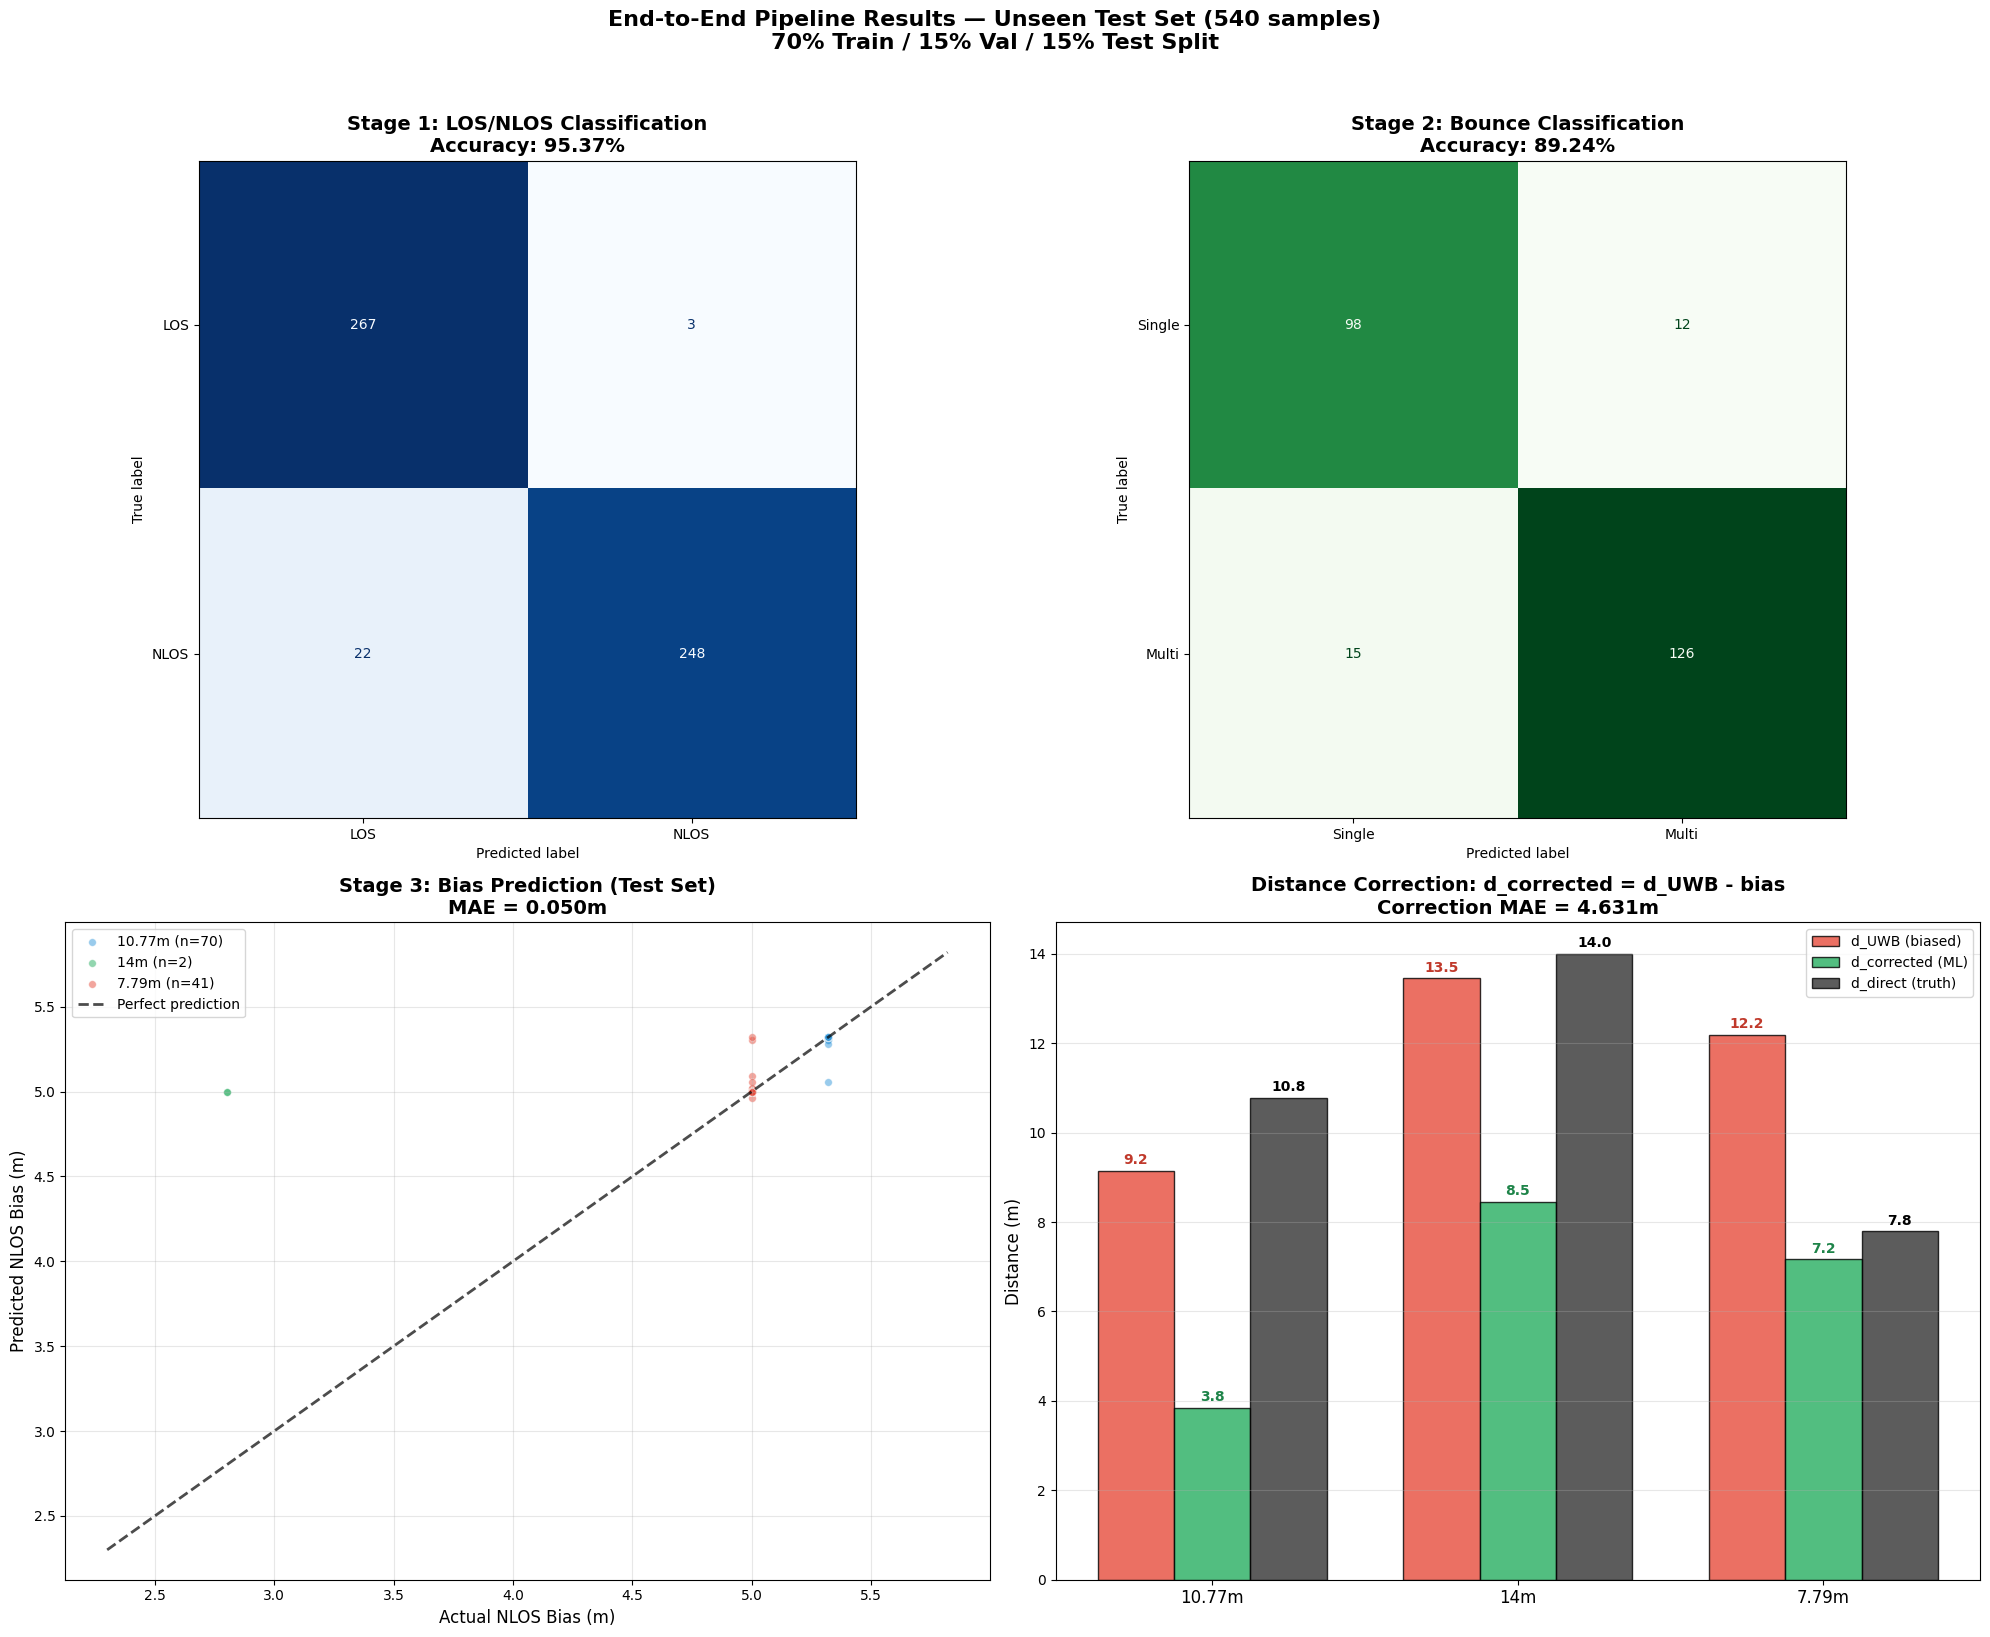

In [9]:
# ==========================================
# VISUALIZATION: 4-PANEL RESULTS
# ==========================================
fig, axs = plt.subplots(2, 2, figsize=(20, 16))
plt.subplots_adjust(hspace=0.35, wspace=0.3)

# --- Panel 1: Stage 1 Confusion Matrix ---
ax = axs[0, 0]
cm1 = confusion_matrix(s1_true, s1_preds)
disp1 = ConfusionMatrixDisplay(cm1, display_labels=['LOS', 'NLOS'])
disp1.plot(ax=ax, cmap='Blues', colorbar=False)
ax.set_title(f'Stage 1: LOS/NLOS Classification\nAccuracy: {100*s1_acc:.2f}%',
             fontsize=14, fontweight='bold')

# --- Panel 2: Stage 2 Confusion Matrix ---
ax = axs[0, 1]
cm2 = confusion_matrix(y_test_bounce_true, s2_preds)
disp2 = ConfusionMatrixDisplay(cm2, display_labels=['Single', 'Multi'])
disp2.plot(ax=ax, cmap='Greens', colorbar=False)
ax.set_title(f'Stage 2: Bounce Classification\nAccuracy: {100*s2_acc:.2f}%',
             fontsize=14, fontweight='bold')

# --- Panel 3: Stage 3 Actual vs Predicted Bias ---
ax = axs[1, 0]
colors_map = {'7.79m': '#e74c3c', '10.77m': '#3498db', '14m': '#27ae60'}
for grp in sorted(GROUND_TRUTH.keys()):
    mask = results_df['group'] == grp
    sub = results_df[mask]
    if len(sub) > 0:
        ax.scatter(sub['actual_bias'], sub['ml_bias'], alpha=0.5, s=30,
                   color=colors_map[grp], label=f'{grp} (n={len(sub)})',
                   edgecolors='white', linewidth=0.5)

all_bias = np.concatenate([results_df['actual_bias'].values, results_df['ml_bias'].values])
lims = [all_bias.min() - 0.5, all_bias.max() + 0.5]
ax.plot(lims, lims, 'k--', lw=2, alpha=0.7, label='Perfect prediction')
ax.set_xlabel('Actual NLOS Bias (m)', fontsize=12)
ax.set_ylabel('Predicted NLOS Bias (m)', fontsize=12)
ax.set_title(f'Stage 3: Bias Prediction (Test Set)\nMAE = {test_mae:.3f}m',
             fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# --- Panel 4: Distance Correction ---
ax = axs[1, 1]
groups_sorted = sorted(GROUND_TRUTH.keys())
x_pos = np.arange(len(groups_sorted))
width = 0.25

d_uwb_vals, d_corr_vals, d_direct_vals = [], [], []
for grp in groups_sorted:
    gt = GROUND_TRUTH[grp]
    sub = results_df[results_df['group'] == grp]
    d_uwb_vals.append(sub['d_uwb'].mean() if len(sub) > 0 else 0)
    d_corr_vals.append(sub['d_corrected'].mean() if len(sub) > 0 else 0)
    d_direct_vals.append(gt['d_direct'])

ax.bar(x_pos - width, d_uwb_vals, width, label='d_UWB (biased)',
       color='#e74c3c', alpha=0.8, edgecolor='black')
ax.bar(x_pos, d_corr_vals, width, label='d_corrected (ML)',
       color='#27ae60', alpha=0.8, edgecolor='black')
ax.bar(x_pos + width, d_direct_vals, width, label='d_direct (truth)',
       color='#333333', alpha=0.8, edgecolor='black')

for i, (u, c, d) in enumerate(zip(d_uwb_vals, d_corr_vals, d_direct_vals)):
    if u > 0:
        ax.text(i - width, u + 0.15, f'{u:.1f}', ha='center', fontsize=10, fontweight='bold', color='#c0392b')
        ax.text(i, c + 0.15, f'{c:.1f}', ha='center', fontsize=10, fontweight='bold', color='#1e8449')
        ax.text(i + width, d + 0.15, f'{d:.1f}', ha='center', fontsize=10, fontweight='bold')

ax.set_xticks(x_pos)
ax.set_xticklabels(groups_sorted, fontsize=12)
ax.set_ylabel('Distance (m)', fontsize=12)
ax.set_title(f'Distance Correction: d_corrected = d_UWB - bias\nCorrection MAE = {results_df["correction_error"].mean():.3f}m',
             fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

fig.suptitle(
    f'End-to-End Pipeline Results — Unseen Test Set ({len(test_df)} samples)\n'
    f'70% Train / 15% Val / 15% Test Split',
    fontsize=16, fontweight='bold', y=1.02
)
plt.tight_layout()
plt.show()

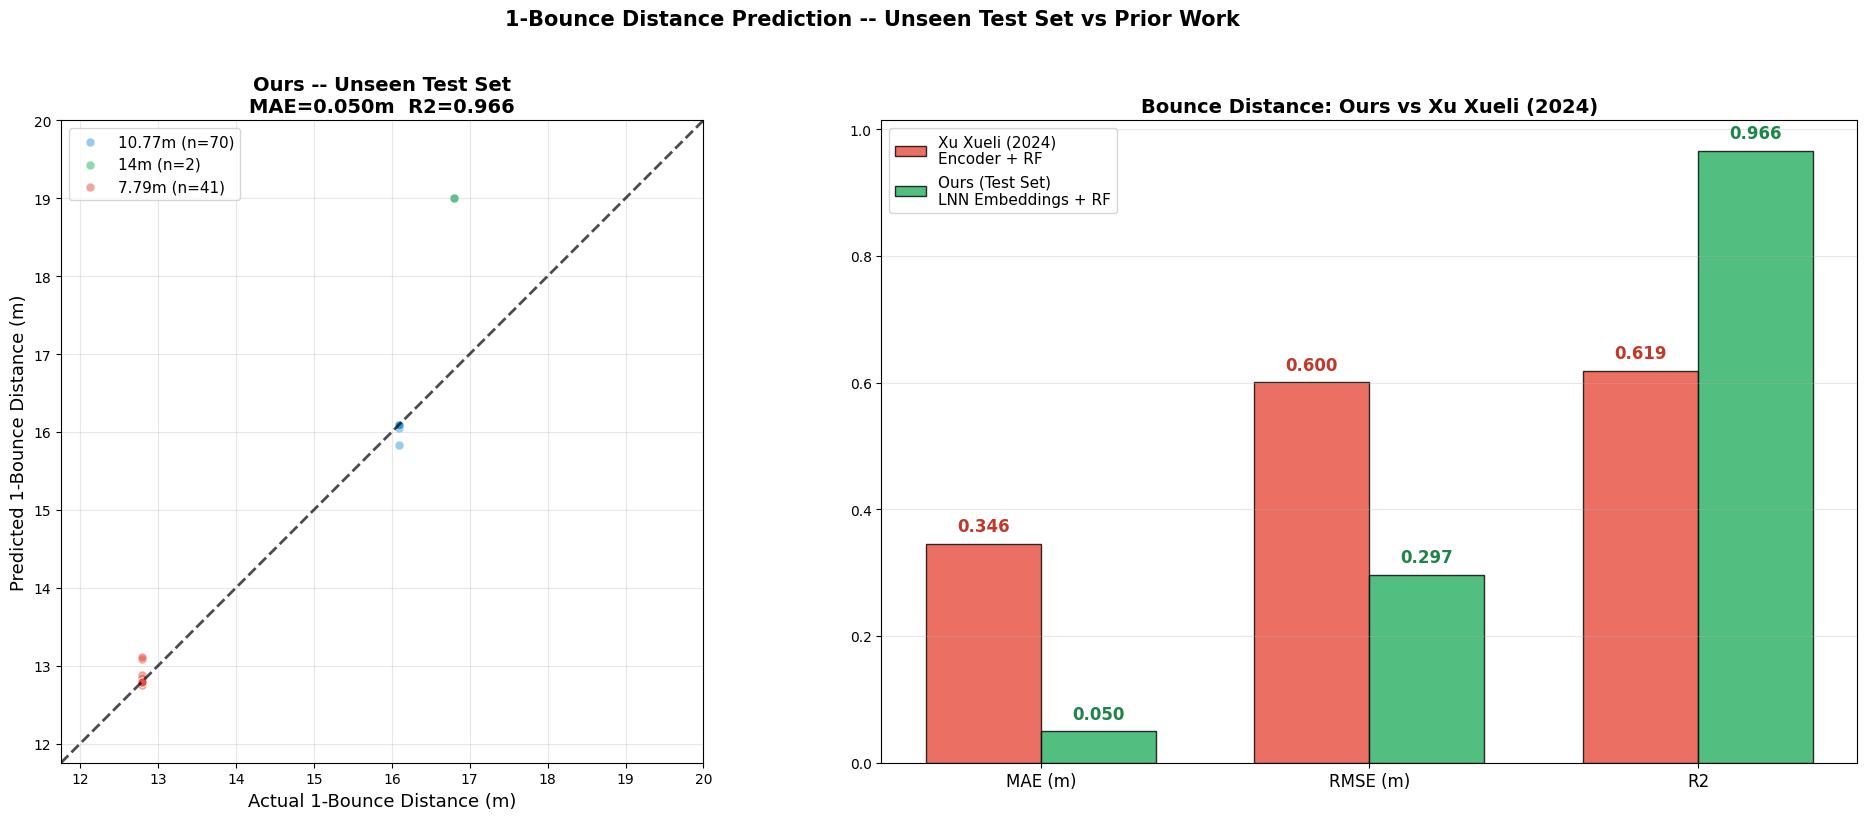


Bounce Distance Benchmark (Unseen Test Set):
  Metric   | Xu Xueli     | Ours         | Improvement
  ------------------------------------------------
  MAE      | 0.346      m | 0.050      m | 6.9x lower
  RMSE     | 0.600      m | 0.297      m | 2.0x lower
  R2       | 0.619        | 0.966        | +0.347


In [10]:
# ==========================================
# BOUNCE DISTANCE BENCHMARK vs Xu Xueli (2024)
# ==========================================
# Derive d_bounce from bias predictions
results_df['actual_d_bounce'] = results_df['group'].map(
    {g: v['d_bounce'] for g, v in GROUND_TRUTH.items()}
)
results_df['predicted_d_bounce'] = results_df.apply(
    lambda r: GROUND_TRUTH[r['group']]['d_direct'] + r['ml_bias'], axis=1
)

our_db_mae = mean_absolute_error(results_df['actual_d_bounce'], results_df['predicted_d_bounce'])
our_db_rmse = np.sqrt(mean_squared_error(results_df['actual_d_bounce'], results_df['predicted_d_bounce']))
our_db_r2 = r2_score(results_df['actual_d_bounce'], results_df['predicted_d_bounce'])

# Xu Xueli's reported metrics
xu_mae, xu_rmse, xu_r2 = 0.34594, 0.60008, 0.61868

fig, axs = plt.subplots(1, 2, figsize=(20, 8))

# Scatter plot
ax = axs[0]
colors_map = {'7.79m': '#e74c3c', '10.77m': '#3498db', '14m': '#27ae60'}
for grp in sorted(GROUND_TRUTH.keys()):
    sub = results_df[results_df['group'] == grp]
    if len(sub) > 0:
        ax.scatter(sub['actual_d_bounce'], sub['predicted_d_bounce'],
                   alpha=0.5, s=40, color=colors_map[grp],
                   edgecolors='white', linewidth=0.5,
                   label=f'{grp} (n={len(sub)})')

all_db = np.concatenate([results_df['actual_d_bounce'].values, results_df['predicted_d_bounce'].values])
lims = [all_db.min() - 1, all_db.max() + 1]
ax.plot(lims, lims, 'k--', lw=2, alpha=0.7)
ax.set_xlabel('Actual 1-Bounce Distance (m)', fontsize=13)
ax.set_ylabel('Predicted 1-Bounce Distance (m)', fontsize=13)
ax.set_title(f'Ours -- Unseen Test Set\nMAE={our_db_mae:.3f}m  R2={our_db_r2:.3f}', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_xlim(lims); ax.set_ylim(lims)
ax.set_aspect('equal')

# Metrics comparison
ax = axs[1]
labels = ['MAE (m)', 'RMSE (m)', 'R2']
xu_v = [xu_mae, xu_rmse, xu_r2]
our_v = [our_db_mae, our_db_rmse, our_db_r2]
x = np.arange(len(labels))
w = 0.35
ax.bar(x - w/2, xu_v, w, label='Xu Xueli (2024)\nEncoder + RF', color='#e74c3c', alpha=0.8, edgecolor='black')
ax.bar(x + w/2, our_v, w, label='Ours (Test Set)\nLNN Embeddings + RF', color='#27ae60', alpha=0.8, edgecolor='black')
for bar, val in zip(ax.containers[0], xu_v):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
            f'{val:.3f}', ha='center', fontsize=12, fontweight='bold', color='#c0392b')
for bar, val in zip(ax.containers[1], our_v):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
            f'{val:.3f}', ha='center', fontsize=12, fontweight='bold', color='#1e8449')
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=12)
ax.set_title('Bounce Distance: Ours vs Xu Xueli (2024)', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')

fig.suptitle('1-Bounce Distance Prediction -- Unseen Test Set vs Prior Work',
             fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print(f'\nBounce Distance Benchmark (Unseen Test Set):')
print(f'  {"Metric":<8} | {"Xu Xueli":<12} | {"Ours":<12} | Improvement')
print(f'  {"-"*48}')
print(f'  {"MAE":<8} | {xu_mae:<11.3f}m | {our_db_mae:<11.3f}m | {xu_mae/our_db_mae:.1f}x lower')
print(f'  {"RMSE":<8} | {xu_rmse:<11.3f}m | {our_db_rmse:<11.3f}m | {xu_rmse/our_db_rmse:.1f}x lower')
print(f'  {"R2":<8} | {xu_r2:<12.3f} | {our_db_r2:<12.3f} | +{our_db_r2 - xu_r2:.3f}')

---
## Section 7: Save Production Models

Save the models trained on the 70% train split for deployment.

In [11]:
# ==========================================
# SAVE PRODUCTION MODELS
# ==========================================
# Stage 1: PyTorch model
torch.save(model_s1.state_dict(), 'prod_stage1_pi_hlnn.pt')

# Stages 2 & 3: sklearn Random Forest
joblib.dump(model_s2, 'prod_stage2_bounce_rf.joblib')
joblib.dump(model_s3, 'prod_stage3_bias_rf.joblib')

# Pipeline config
torch.save({
    'stage1_config': S1_CONFIG,
    'embedding_dim': EMBEDDING_DIM,
    'embedding_names': EMBEDDING_NAMES,
    'ground_truth': GROUND_TRUTH,
    'measured_nlos_bias': MEASURED_NLOS_BIAS,
    'peak_config': PEAK_CONFIG,
    'note': 'Stages 2 & 3 use 48-dim LNN embeddings from frozen Stage 1 PI-HLNN',
}, 'prod_pipeline_config.pt')

print('Saved production models:')
print('  prod_stage1_pi_hlnn.pt       (PyTorch)')
print('  prod_stage2_bounce_rf.joblib (sklearn RF)')
print('  prod_stage3_bias_rf.joblib   (sklearn RF)')
print('  prod_pipeline_config.pt      (config dict)')

Saved production models:
  prod_stage1_pi_hlnn.pt       (PyTorch)
  prod_stage2_bounce_rf.joblib (sklearn RF)
  prod_stage3_bias_rf.joblib   (sklearn RF)
  prod_pipeline_config.pt      (config dict)


In [12]:
# ==========================================
# FINAL SUMMARY
# ==========================================
print('='*70)
print('MULTI-MODEL PIPELINE -- FINAL RESULTS')
print('='*70)
print(f'\nData Split: 70/15/15 (Train={len(train_df)}, Val={len(val_df)}, Test={len(test_df)})')
print(f'\nPipeline Architecture:')
print(f'  Stage 1: PI-HLNN (Liquid Neural Network)    -- {sum(p.numel() for p in model_s1.parameters()):,} params')
print(f'  Stage 2: Random Forest Bounce Classifier     -- {model_s2.n_estimators} trees, {EMBEDDING_DIM}-dim LNN embeddings')
print(f'           Input: Frozen Stage 1 PI-HLNN encoder -> {EMBEDDING_DIM}-dim h_pooled')
print(f'  Stage 3: Random Forest Bias Regressor        -- {model_s3.n_estimators} trees, {EMBEDDING_DIM}-dim LNN embeddings')
print(f'           Input: Frozen Stage 1 PI-HLNN encoder -> {EMBEDDING_DIM}-dim h_pooled')
print(f'\nResults on Unseen Test Set ({len(test_df)} samples):')
print(f'  Stage 1 (LOS/NLOS):      {100*s1_acc:.2f}% accuracy')
print(f'  Stage 2 (Bounce type):   {100*s2_acc:.2f}% accuracy')
print(f'  Stage 3 (Bias):          MAE = {test_mae:.4f}m')
print(f'  Distance correction:     MAE = {results_df["correction_error"].mean():.4f}m')
print(f'\nBenchmark vs Xu Xueli (2024):')
print(f'  Bounce distance MAE: {our_db_mae:.3f}m (ours) vs {xu_mae:.3f}m (Xu Xueli)')
print(f'  Bounce distance R2:  {our_db_r2:.3f} (ours) vs {xu_r2:.3f} (Xu Xueli)')
print(f'\nPipeline flow on test set:')
print(f'  {len(test_df)} total')
print(f'  -> {int(nlos_mask_pred.sum())} classified as NLOS (Stage 1)')
print(f'  -> {int(single_mask_pred.sum())} classified as single-bounce (Stage 2)')
print(f'  -> {len(results_df)} bias predicted + distance corrected (Stage 3)')
print(f'\nAt inference: d_corrected = d_UWB - predicted_bias')

MULTI-MODEL PIPELINE -- FINAL RESULTS

Data Split: 70/15/15 (Train=2520, Val=540, Test=540)

Pipeline Architecture:
  Stage 1: PI-HLNN (Liquid Neural Network)    -- 7,233 params
  Stage 2: Random Forest Bounce Classifier     -- 200 trees, 48-dim LNN embeddings
           Input: Frozen Stage 1 PI-HLNN encoder -> 48-dim h_pooled
  Stage 3: Random Forest Bias Regressor        -- 200 trees, 48-dim LNN embeddings
           Input: Frozen Stage 1 PI-HLNN encoder -> 48-dim h_pooled

Results on Unseen Test Set (540 samples):
  Stage 1 (LOS/NLOS):      95.37% accuracy
  Stage 2 (Bounce type):   89.24% accuracy
  Stage 3 (Bias):          MAE = 0.0498m
  Distance correction:     MAE = 4.6310m

Benchmark vs Xu Xueli (2024):
  Bounce distance MAE: 0.050m (ours) vs 0.346m (Xu Xueli)
  Bounce distance R2:  0.966 (ours) vs 0.619 (Xu Xueli)

Pipeline flow on test set:
  540 total
  -> 251 classified as NLOS (Stage 1)
  -> 113 classified as single-bounce (Stage 2)
  -> 113 bias predicted + distance corr